# Predictor Tool Models Notebook

This notebook contains all the models in the winner prediction tool fitted on the all races combined dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from matplotlib import rcParams
import csv
import collections
import time

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Best Predictor

In [3]:
# Load the data
data = pd.read_csv('../StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()


# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

# Calculate the 80th percentile of the 'Frame' column within each group of 'ReplayID'
percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(0.8)

# Define a function to find the row with the closest 'Frame' value to the 80th percentile within each group
def find_nearest_row(group):
    nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
    return group.loc[[nearest_index]]

# Apply the function to each group of 'ReplayID' and concatenate the results
nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)

# Define features (X) and target variable (y)
X = nearest_rows[['MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player1_ECmdCount', 'Player1_Race', 'Player2_EAPM', 'Player2_ECmdCount', 'Player2_Race', 'Player1_TotalUnits', 'Player1_AliveUnits', 'Player2_TotalUnits', 'Player2_AliveUnits']]
y = nearest_rows['Winner']
nearest_rows.sample(5, random_state=42)
X.sample(50, random_state=42).to_csv("testing_simple.csv", index=False)
y.sample(50, random_state=42).to_csv("testing_simple_y.csv", index=False)

def testing_prediction(per):
    # last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

    # Calculate the 80th percentile of the 'Frame' column within each group of 'ReplayID'
    percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(per)

    # Define a function to find the row with the closest 'Frame' value to the 80th percentile within each group
    def find_nearest_row(group):
        nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
        return group.loc[[nearest_index]]

    # Apply the function to each group of 'ReplayID' and concatenate the results
    nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)

    label_encoders = {}

    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

    # Reset the index if needed
    nearest_rows.reset_index(drop=True, inplace=True)
    # Define features (X) and target variable (y)
    X = nearest_rows[['MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player1_ECmdCount', 'Player1_Race', 'Player2_EAPM', 'Player2_ECmdCount', 'Player2_Race', 'Player1_TotalUnits', 'Player1_AliveUnits', 'Player2_TotalUnits', 'Player2_AliveUnits']]
    y = nearest_rows['Winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

    # Initialize the RandomForestClassifier (you can choose other classifiers as well)
    clf = RandomForestClassifier()

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    # print(f'Accuracy: {accuracy:.2f}')
    y_test.to_numpy().flatten()
    pred_test = pd.read_csv('testing_simple.csv')
    y_pred = clf.predict(pred_test)
    y_test = pd.read_csv('testing_simple_y.csv').to_numpy().flatten()
    score = accuracy_score(y_test, y_pred)
    print("Game Quantile: ",per, " Accuracy:", score)

for i in range(10, 110, 10):
    testing_prediction(i / 100)

Game Quantile:  0.1  Accuracy: 0.68
Game Quantile:  0.2  Accuracy: 0.74
Game Quantile:  0.3  Accuracy: 0.68
Game Quantile:  0.4  Accuracy: 0.76
Game Quantile:  0.5  Accuracy: 0.74
Game Quantile:  0.6  Accuracy: 0.82
Game Quantile:  0.7  Accuracy: 0.84
Game Quantile:  0.8  Accuracy: 0.92
Game Quantile:  0.9  Accuracy: 0.86
Game Quantile:  1.0  Accuracy: 0.92


# Time based prediction

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()


# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

# Calculate the 80th percentile of the 'Frame' column within each group of 'ReplayID'
percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(0.6)

# Define a function to find the row with the closest 'Frame' value to the 80th percentile within each group
def find_nearest_row(group):
    nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
    return group.loc[[nearest_index]]

# Apply the function to each group of 'ReplayID' and concatenate the results
nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)

# Define features (X) and target variable (y)
X = nearest_rows[['MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player1_ECmdCount', 'Player1_Race', 'Player2_EAPM', 'Player2_ECmdCount', 'Player2_Race', 'Player1_TotalUnits', 'Player1_AliveUnits', 'Player2_TotalUnits', 'Player2_AliveUnits']]
y = nearest_rows['Winner']
nearest_rows.sample(5, random_state=42)
X.sample(50, random_state=42).to_csv("testing_simple.csv", index=False)
y.sample(50, random_state=42).to_csv("testing_simple_y.csv", index=False)

def testing_prediction(per):
    # last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

    # nearest_rows = data[data['Frame'] == 1800 * per]
    # using .loc[row_indexer,col_indexer]
    nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                            apply(lambda x: (x - 1800 * per).abs().idxmin())]

    label_encoders = {}

    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

    # Reset the index if needed
    nearest_rows.reset_index(drop=True, inplace=True)
    # Define features (X) and target variable (y)
    X = nearest_rows[['MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player1_ECmdCount', 'Player1_Race', 'Player2_EAPM', 'Player2_ECmdCount', 'Player2_Race', 'Player1_TotalUnits', 'Player1_AliveUnits', 'Player2_TotalUnits', 'Player2_AliveUnits']]
    y = nearest_rows['Winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

    # Initialize the RandomForestClassifier (you can choose other classifiers as well)
    clf = RandomForestClassifier()

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    # print(f'Accuracy: {accuracy:.2f}')
    y_test.to_numpy().flatten()
    pred_test = pd.read_csv('testing_simple.csv')
    y_pred = clf.predict(pred_test)
    y_test = pd.read_csv('testing_simple_y.csv').to_numpy().flatten()
    score = accuracy_score(y_test, y_pred)
    print("Game Progressed Minutes: ",per, " Accuracy:", score)

max_frame = data['Frame'].max() // 1800
for i in range(0, max_frame, 1):
    testing_prediction(i)

Game Progressed Minutes:  0  Accuracy: 0.62
Game Progressed Minutes:  1  Accuracy: 0.64
Game Progressed Minutes:  2  Accuracy: 0.72
Game Progressed Minutes:  3  Accuracy: 0.6
Game Progressed Minutes:  4  Accuracy: 0.78
Game Progressed Minutes:  5  Accuracy: 0.7
Game Progressed Minutes:  6  Accuracy: 0.64
Game Progressed Minutes:  7  Accuracy: 0.74
Game Progressed Minutes:  8  Accuracy: 0.66
Game Progressed Minutes:  9  Accuracy: 0.74
Game Progressed Minutes:  10  Accuracy: 0.84
Game Progressed Minutes:  11  Accuracy: 0.84
Game Progressed Minutes:  12  Accuracy: 0.8
Game Progressed Minutes:  13  Accuracy: 0.84
Game Progressed Minutes:  14  Accuracy: 0.82
Game Progressed Minutes:  15  Accuracy: 0.82
Game Progressed Minutes:  16  Accuracy: 0.82
Game Progressed Minutes:  17  Accuracy: 0.78
Game Progressed Minutes:  18  Accuracy: 0.84
Game Progressed Minutes:  19  Accuracy: 0.86
Game Progressed Minutes:  20  Accuracy: 0.78
Game Progressed Minutes:  21  Accuracy: 0.88
Game Progressed Minutes

In [ ]:
data['Duration'].value_counts().sort_values()

Duration
4712       47
5236       53
5506       55
5634       57
5670       57
         ... 
44892     898
46125     924
49190     984
51087    1022
54433    1090
Name: count, Length: 2178, dtype: int64

# Top Features

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# drop winner more than 2
data = data.drop(data[data['Winner'] > 2].index)

# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()


# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

# Calculate the 80th percentile of the 'Frame' column within each group of 'ReplayID'
percentile_80_grouped = data.groupby('ReplayID')['Frame'].quantile(0.5)

# Define a function to find the row with the closest 'Frame' value to the 80th percentile within each group
def find_nearest_row(group):
    nearest_index = (group['Frame'] - percentile_80_grouped[group.name]).abs().idxmin()
    return group.loc[[nearest_index]]

# Apply the function to each group of 'ReplayID' and concatenate the results
nearest_rows = data.groupby('ReplayID', group_keys=False).apply(find_nearest_row)

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)

# Define features (X) and target variable (y)
X = nearest_rows.drop(columns=['Winner'], axis=1)
y = nearest_rows['Winner']
nearest_rows.sample(5, random_state=42)
X.sample(50, random_state=42).to_csv("testing_simple.csv", index=False)
y.sample(50, random_state=42).to_csv("testing_simple_y.csv", index=False)

def testing_prediction(per):
    # last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

    # nearest_rows = data[data['Frame'] == 1800 * per]
    # using .loc[row_indexer,col_indexer]
    nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                            apply(lambda x: (x - 1800 * per).abs().idxmin())]

    label_encoders = {}

    for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
        label_encoders[column] = LabelEncoder()
        nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

    # Reset the index if needed
    nearest_rows.reset_index(drop=True, inplace=True)
    # Define features (X) and target variable (y)
    X = nearest_rows.drop(columns=['Winner'], axis=1)
    y = nearest_rows['Winner']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

    # Initialize the RandomForestClassifier (you can choose other classifiers as well)
    clf = RandomForestClassifier()

    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {per} {accuracy:.2f}')
    # y_test.to_numpy().flatten()
    # pred_test = pd.read_csv('testing_simple.csv')
    # y_pred = clf.predict(pred_test)
    # y_test = pd.read_csv('testing_simple_y.csv').to_numpy().flatten()
    # score = accuracy_score(y_test, y_pred)
    # print(per, score)

max_frame = data['Frame'].max() // 1800
for i in range(0, max_frame, 1):
    testing_prediction(i)

Accuracy: 0 0.64
Accuracy: 1 0.68
Accuracy: 2 0.66
Accuracy: 3 0.67
Accuracy: 4 0.68
Accuracy: 5 0.68
Accuracy: 6 0.67
Accuracy: 7 0.68
Accuracy: 8 0.67
Accuracy: 9 0.70
Accuracy: 10 0.72
Accuracy: 11 0.72
Accuracy: 12 0.71
Accuracy: 13 0.73
Accuracy: 14 0.73
Accuracy: 15 0.74
Accuracy: 16 0.76
Accuracy: 17 0.76
Accuracy: 18 0.78
Accuracy: 19 0.78
Accuracy: 20 0.80
Accuracy: 21 0.80
Accuracy: 22 0.83
Accuracy: 23 0.82
Accuracy: 24 0.81
Accuracy: 25 0.83
Accuracy: 26 0.84
Accuracy: 27 0.85
Accuracy: 28 0.85
Accuracy: 29 0.85
Accuracy: 30 0.85
Accuracy: 31 0.86
Accuracy: 32 0.86
Accuracy: 33 0.86
Accuracy: 34 0.85


In [ ]:
nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                        apply(lambda x: (x - 1800 * 15).abs().idxmin())]

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)
# Define features (X) and target variable (y)
X = nearest_rows.drop(columns=['Winner'], axis=1)
y = nearest_rows['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=101) # 70% training and 30% test

# Initialize the RandomForestClassifier (you can choose other classifiers as well)
clf = RandomForestClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {20} {accuracy:.2f}')

Accuracy: 20 0.72


In [ ]:
# All Correlating Features
feature_importances = clf.feature_importances_
feature_importances = 100.0 * (feature_importances / feature_importances.max())

sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(20, 70))
plt.barh(pos, feature_importances[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

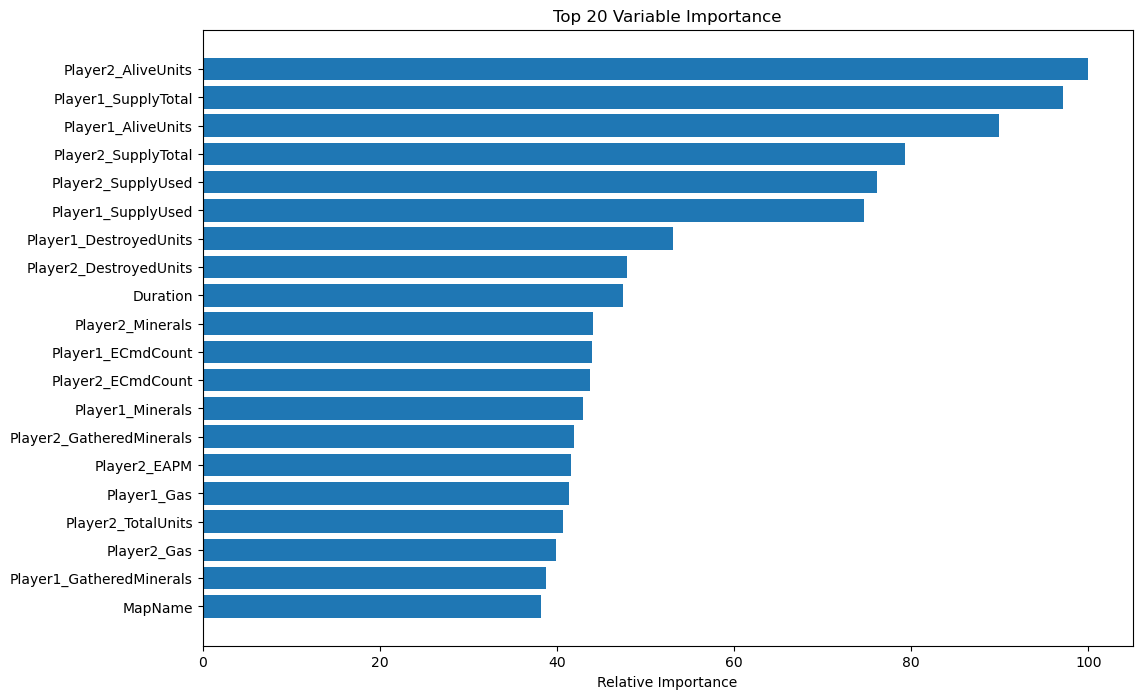

In [ ]:
# give the top five important features
feature_importances = clf.feature_importances_
feature_importances = 100.0 * (feature_importances / feature_importances.max())

sorted_idx = np.argsort(feature_importances)[-20:]  # Get the indices of the top 10 features
pos = np.arange(sorted_idx.shape[0]) + .5

# Plot only the top 10 features
plt.figure(figsize=(12, 8))
plt.barh(pos, feature_importances[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Top 20 Variable Importance')
plt.show()

In [ ]:
myClassifiers = pd.Series(feature_importances, index=X_train.columns)
print(myClassifiers.sort_values(ascending=False))


Player2_AliveUnits                100.000000
Player1_SupplyTotal                97.132533
Player1_AliveUnits                 89.972358
Player2_SupplyTotal                79.340988
Player2_SupplyUsed                 76.086743
                                     ...    
Player2_Moebius Reactor_Level       0.000000
Player2_Colossus Reactor_Level      0.000000
Player2_Alive_Protoss Archon        0.000000
Player2_Caduceus Reactor_Level      0.000000
Player2_Alive_Zerg Broodling        0.000000
Length: 348, dtype: float64


# Random Forest

### Simple Model

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
# drop winner more than 2
data = data.drop(data[data['Winner'] > 2].index)

# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                        apply(lambda x: (x - 1800 * 16).abs().idxmin())]

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)

In [ ]:
# Define features (X) and target variable (y)
X = nearest_rows[["Player1_Race","Player2_Race","Player1_AliveUnits","Player2_AliveUnits","Player1_SupplyUsed","Player2_SupplyUsed","Player1_Gas","Player2_Gas", "Player1_Minerals", "Player2_Minerals"]]
y = nearest_rows['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101) # 70% training and 30% test

# Initialize the RandomForestClassifier (you can choose other classifiers as well)
clf = RandomForestClassifier(random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {20} {accuracy:.2f}')

Accuracy: 20 0.83


In [ ]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from joblib import dump, load

dump(clf, 'simple_random_forest_model.joblib') 


['simple_random_forest_model.joblib']

### Game State Predictor

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
# drop winner more than 2
data = data.drop(data[data['Winner'] > 2].index)

# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                        apply(lambda x: (x - 1800 * 16).abs().idxmin())]

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)



In [ ]:
# Define features (X) and target variable (y)
X = nearest_rows[['Player1_Race','Player2_Race','MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player2_EAPM', 'Player1_ECmdCount', 'Player2_ECmdCount', 'Player1_TotalUnits', 'Player2_TotalUnits', 'Player1_AliveUnits', 'Player2_AliveUnits']]
y = nearest_rows['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 70% training and 30% test
from sklearn.metrics import accuracy_score, classification_report

clf = RandomForestClassifier()

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.74


In [ ]:
from joblib import dump, load

dump(clf, 'gameState_random_forest_model.joblib') 


['gameState_random_forest_model.joblib']

In [ ]:
nearest_rows['MapName_decoded'] = label_encoders['MapName'].inverse_transform(nearest_rows['MapName'])

In [ ]:
# give dictionary of map names encoed and its decoded names
map_names = nearest_rows[["MapName", "MapName_decoded"]]

map_names = map_names.drop_duplicates()
map_names.set_index('MapName', inplace=True)

In [ ]:
map_names.sort_index().to_dict()

{'MapName_decoded': {0: '\x01(4)\x03NsP Clan \x07Lost Temple',
  1: '\x01Neo \x06Vertigo',
  2: '\x01sG Vertigo',
  3: '\x02G\x06orky \x02I\x06sland',
  4: '\x02G\x06orky \x02P\x06ark',
  5: '\x03Another \x07Day',
  6: '\x03B\x04yzantium \x02II \x052.2',
  7: '\x03B\x04yzantium \x051.0',
  8: '\x03Circuit Breakers \x051.0',
  9: '\x03Gaia 1.0',
  10: '\x03Guillotine',
  11: '\x03KiSaDan\x04T\x07em\x01p\x07le\x01',
  12: '\x03Korhal \x06of \x07Ceres',
  13: '\x03L\x04o\x03s\x04t \x03Te\x03m\x04p\x03l\x04e \x04SaSi',
  14: '\x03L\x04o\x03s\x04t \x03Te\x03m\x04p\x03l\x04e \x06[WHI',
  15: '\x03L\x04una',
  16: '\x03L\x04una \x06the \x07Final',
  17: '\x03Loki \x05II',
  18: '\x03Lost \x07Temple \x04- JoyDoM',
  19: '\x03Lu\x04na',
  20: '\x03Monty \x02Hall\x06_SE \x052.1',
  21: '\x03Monty \x02Hall \x051.1',
  22: '\x03N\x04eo \x06Aztec\x052.0',
  23: '\x03Neo\x06MoonGlaive\x052.1',
  24: '\x03Neo \x04Bifrost',
  25: '\x03Neo \x06Silent \x04Vortex',
  26: '\x03Rush Hour 3.03',
  27: '\x03

In [ ]:
nearest_rows["MapWidth"].value_counts()

MapWidth
128    1944
96      270
112      21
64        1
Name: count, dtype: int64

# SVM Model

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
# drop winner more than 2
data = data.drop(data[data['Winner'] > 2].index)

# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                        apply(lambda x: (x - 1800 * 16).abs().idxmin())]

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)



### Simple

In [ ]:
from sklearn import svm #Import svm model


# Define features (X) and target variable (y)
X = nearest_rows[["Player1_Race","Player2_Race","Player1_AliveUnits","Player2_AliveUnits","Player1_SupplyUsed","Player2_SupplyUsed","Player1_Gas","Player2_Gas", "Player1_Minerals", "Player2_Minerals"]]
y = nearest_rows['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 70% training and 30% test

clf = svm.LinearSVC(C=0.00001, random_state=42) # Linear Kernel

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.74


c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
dump(clf, 'simple_svm_model.joblib') 

['simple_svm_model.joblib']

### Game State

In [ ]:
# Define features (X) and target variable (y)
X = nearest_rows[['Player1_Race','Player2_Race','MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player2_EAPM', 'Player1_ECmdCount', 'Player2_ECmdCount', 'Player1_TotalUnits', 'Player2_TotalUnits', 'Player1_AliveUnits', 'Player2_AliveUnits']]
y = nearest_rows['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test

clf = svm.LinearSVC(C=0.00001, random_state=42) # Linear Kernel

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.71


c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\abhin\anaconda3\envs\DevelopmentEnv\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
dump(clf, 'gameState_svm_model.joblib') 

['gameState_svm_model.joblib']

# Logistic Regression Model

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
# drop winner more than 2
data = data.drop(data[data['Winner'] > 2].index)

# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                        apply(lambda x: (x - 1800 * 16).abs().idxmin())]

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)



### Simple

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


# Define features (X) and target variable (y)
X = nearest_rows[["Player1_Race","Player2_Race","Player1_AliveUnits","Player2_AliveUnits","Player1_SupplyUsed","Player2_SupplyUsed","Player1_Gas","Player2_Gas", "Player1_Minerals", "Player2_Minerals"]]
y = nearest_rows['Winner']
num_columns = X.select_dtypes(include=['int64', 'float64']).columns
ct = make_column_transformer(
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X = ct.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 70% training and 30% test

clf = LogisticRegression(solver='liblinear', max_iter=100, C=1)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.74


In [ ]:
dump(clf, 'simple_LR_model.joblib') 

['simple_LR_model.joblib']

### Game State

In [ ]:
# Define features (X) and target variable (y)
X = nearest_rows[['Player1_Race','Player2_Race','MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player2_EAPM', 'Player1_ECmdCount', 'Player2_ECmdCount', 'Player1_TotalUnits', 'Player2_TotalUnits', 'Player1_AliveUnits', 'Player2_AliveUnits']]
y = nearest_rows['Winner']
num_columns = X.select_dtypes(include=['int64', 'float64']).columns
ct = make_column_transformer(
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X = ct.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test

clf = LogisticRegression(solver='liblinear', max_iter=100, C=1)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.74


In [ ]:
dump(clf, 'gameState_LR_model.joblib') 

['gameState_LR_model.joblib']

# KNN Model

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
# drop winner more than 2
data = data.drop(data[data['Winner'] > 2].index)

# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                        apply(lambda x: (x - 1800 * 16).abs().idxmin())]

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)



### Simple

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


# Define features (X) and target variable (y)
X = nearest_rows[["Player1_Race","Player2_Race","Player1_AliveUnits","Player2_AliveUnits","Player1_SupplyUsed","Player2_SupplyUsed","Player1_Gas","Player2_Gas", "Player1_Minerals", "Player2_Minerals"]]
print(X.shape)
y = nearest_rows['Winner']
num_columns = X.select_dtypes(include=['int64', 'float64']).columns
ct = make_column_transformer(
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X = ct.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 70% training and 30% test

clf = KNeighborsClassifier(n_jobs=-1, weights='distance')

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

(2233, 10)
Accuracy: 0.74


In [ ]:
X.shape

(2233, 10)

In [ ]:
dump(clf, 'simple_KNN_model.joblib') 

['simple_KNN_model.joblib']

### Game State

In [ ]:
# Define features (X) and target variable (y)
X = nearest_rows[['Player1_Race','Player2_Race','MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player2_EAPM', 'Player1_ECmdCount', 'Player2_ECmdCount', 'Player1_TotalUnits', 'Player2_TotalUnits', 'Player1_AliveUnits', 'Player2_AliveUnits']]
y = nearest_rows['Winner']
num_columns = X.select_dtypes(include=['int64', 'float64']).columns
ct = make_column_transformer(
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

X = ct.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test

clf = KNeighborsClassifier(n_jobs=-1, weights='distance')

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.59


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_neighbors": list(range(1, 20,1)),
    "weights": ["uniform", "distance"],
}

knn = KNeighborsClassifier(n_jobs=-1)

clf = RandomizedSearchCV(knn, param_grid, n_jobs=-1, n_iter=3, verbose=2, cv=3)

clf.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_iter=3,
                   n_jobs=-1,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19],
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [ ]:
clf.best_score_

0.5662188099808061

In [ ]:
dump(clf, 'gameState_KNN_model.joblib') 

['gameState_KNN_model.joblib']

# Decision Trees Model

In [ ]:
# Load the data
data = pd.read_csv('All/StarCraft_Combined_Dataset.csv')  # Replace with your actual file path

# Assuming combined_data is your DataFrame
data = data.drop(data[data['Winner'] == 0].index)
# Assuming df is your DataFrame and 'ReplayID' is the column to be encoded
label_encoder = LabelEncoder()
# drop winner more than 2
data = data.drop(data[data['Winner'] > 2].index)

# convert 1 to 0 and 2 to 1
data['Winner'] = data['Winner'].replace(1, 0)
data['Winner'] = data['Winner'].replace(2, 1)

# last_rows = data.groupby('ReplayID').tail(70).groupby('ReplayID').head(1)

nearest_rows = data.loc[data.groupby('ReplayID')['Frame'].
                        apply(lambda x: (x - 1800 * 16).abs().idxmin())]

label_encoders = {}

for column in ['ReplayID', 'Player1_Race', 'Player2_Race', 'MapName']:
    label_encoders[column] = LabelEncoder()
    nearest_rows[column] = label_encoders[column].fit_transform(nearest_rows[column])

# Reset the index if needed
nearest_rows.reset_index(drop=True, inplace=True)



### Simple

In [ ]:
from sklearn.tree import DecisionTreeClassifier


# Define features (X) and target variable (y)
X = nearest_rows[["Player1_Race","Player2_Race","Player1_AliveUnits","Player2_AliveUnits","Player1_SupplyUsed","Player2_SupplyUsed","Player1_Gas","Player2_Gas", "Player1_Minerals", "Player2_Minerals"]]
y = nearest_rows['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 70% training and 30% test

clf = DecisionTreeClassifier(min_samples_split=10,max_depth=6)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.75


In [ ]:
dump(clf, 'simple_DT_model.joblib') 

['simple_DT_model.joblib']

### Game State

In [ ]:
# Define features (X) and target variable (y)
X = nearest_rows[['Player1_Race','Player2_Race','MapName','MapWidth', 'MapHeight', 'Player1_EAPM', 'Player2_EAPM', 'Player1_ECmdCount', 'Player2_ECmdCount', 'Player1_TotalUnits', 'Player2_TotalUnits', 'Player1_AliveUnits', 'Player2_AliveUnits']]
y = nearest_rows['Winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test

clf = DecisionTreeClassifier(min_samples_split=10,max_depth=6)

# Train the model
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.70


In [ ]:
dump(clf, 'gameState_DT_model.joblib') 

['gameState_DT_model.joblib']